# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 9043968/11490434 [======================>.......] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 13:49 - loss: 0.6932

  22/1875 [..............................] - ETA: 4s - loss: 0.5783   

  54/1875 [..............................] - ETA: 3s - loss: 0.4740

  85/1875 [>.............................] - ETA: 3s - loss: 0.4259

 110/1875 [>.............................] - ETA: 3s - loss: 0.4013

 126/1875 [=>............................] - ETA: 3s - loss: 0.3890

 151/1875 [=>............................] - ETA: 3s - loss: 0.3734

 177/1875 [=>............................] - ETA: 3s - loss: 0.3602

 201/1875 [==>...........................] - ETA: 3s - loss: 0.3499

 225/1875 [==>...........................] - ETA: 3s - loss: 0.3409

 251/1875 [===>..........................] - ETA: 3s - loss: 0.3324

 278/1875 [===>..........................] - ETA: 3s - loss: 0.3245

 304/1875 [===>..........................] - ETA: 3s - loss: 0.3178

 334/1875 [====>.........................] - ETA: 3s - loss: 0.3108

 361/1875 [====>.........................] - ETA: 3s - loss: 0.3051

 388/1875 [=====>........................] - ETA: 2s - loss: 0.2999

 417/1875 [=====>........................] - ETA: 2s - loss: 0.2947

 443/1875 [======>.......................] - ETA: 2s - loss: 0.2904

 469/1875 [======>.......................] - ETA: 2s - loss: 0.2864

 487/1875 [======>.......................] - ETA: 2s - loss: 0.2838

 503/1875 [=======>......................] - ETA: 2s - loss: 0.2815

 527/1875 [=======>......................] - ETA: 2s - loss: 0.2783

 556/1875 [=======>......................] - ETA: 2s - loss: 0.2747

 587/1875 [========>.....................] - ETA: 2s - loss: 0.2710

 611/1875 [========>.....................] - ETA: 2s - loss: 0.2684

 633/1875 [=========>....................] - ETA: 2s - loss: 0.2660

 662/1875 [=========>....................] - ETA: 2s - loss: 0.2631

 685/1875 [=========>....................] - ETA: 2s - loss: 0.2609

 712/1875 [==========>...................] - ETA: 2s - loss: 0.2584

 729/1875 [==========>...................] - ETA: 2s - loss: 0.2569

 750/1875 [===========>..................] - ETA: 2s - loss: 0.2550

 773/1875 [===========>..................] - ETA: 2s - loss: 0.2531

 800/1875 [===========>..................] - ETA: 2s - loss: 0.2509

 831/1875 [============>.................] - ETA: 2s - loss: 0.2486

 863/1875 [============>.................] - ETA: 2s - loss: 0.2462

 889/1875 [=============>................] - ETA: 2s - loss: 0.2444

 922/1875 [=============>................] - ETA: 1s - loss: 0.2421

 951/1875 [==============>...............] - ETA: 1s - loss: 0.2402

 982/1875 [==============>...............] - ETA: 1s - loss: 0.2383

1007/1875 [===============>..............] - ETA: 1s - loss: 0.2368

1032/1875 [===============>..............] - ETA: 1s - loss: 0.2353

1060/1875 [===============>..............] - ETA: 1s - loss: 0.2337

1087/1875 [================>.............] - ETA: 1s - loss: 0.2322

1114/1875 [================>.............] - ETA: 1s - loss: 0.2307

1138/1875 [=================>............] - ETA: 1s - loss: 0.2295

1165/1875 [=================>............] - ETA: 1s - loss: 0.2281

1193/1875 [==================>...........] - ETA: 1s - loss: 0.2267

1225/1875 [==================>...........] - ETA: 1s - loss: 0.2252

1251/1875 [===================>..........] - ETA: 1s - loss: 0.2240

1284/1875 [===================>..........] - ETA: 1s - loss: 0.2225

1316/1875 [====================>.........] - ETA: 1s - loss: 0.2211

1343/1875 [====================>.........] - ETA: 1s - loss: 0.2199

1369/1875 [====================>.........] - ETA: 0s - loss: 0.2188

1399/1875 [=====================>........] - ETA: 0s - loss: 0.2176

1428/1875 [=====================>........] - ETA: 0s - loss: 0.2164

1452/1875 [======================>.......] - ETA: 0s - loss: 0.2155

1476/1875 [======================>.......] - ETA: 0s - loss: 0.2146

1504/1875 [=======================>......] - ETA: 0s - loss: 0.2136

1533/1875 [=======================>......] - ETA: 0s - loss: 0.2125

1559/1875 [=======================>......] - ETA: 0s - loss: 0.2116

1592/1875 [========================>.....] - ETA: 0s - loss: 0.2104

1624/1875 [========================>.....] - ETA: 0s - loss: 0.2093

1647/1875 [=========================>....] - ETA: 0s - loss: 0.2086

1669/1875 [=========================>....] - ETA: 0s - loss: 0.2079

1689/1875 [==========================>...] - ETA: 0s - loss: 0.2072

1705/1875 [==========================>...] - ETA: 0s - loss: 0.2067

1726/1875 [==========================>...] - ETA: 0s - loss: 0.2061

1744/1875 [==========================>...] - ETA: 0s - loss: 0.2055

1765/1875 [===========================>..] - ETA: 0s - loss: 0.2049

1791/1875 [===========================>..] - ETA: 0s - loss: 0.2041

1812/1875 [===========================>..] - ETA: 0s - loss: 0.2035

1833/1875 [============================>.] - ETA: 0s - loss: 0.2029

1855/1875 [============================>.] - ETA: 0s - loss: 0.2022

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2016


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1148

  22/1875 [..............................] - ETA: 4s - loss: 0.1087

  40/1875 [..............................] - ETA: 4s - loss: 0.1088

  62/1875 [..............................] - ETA: 4s - loss: 0.1089

  79/1875 [>.............................] - ETA: 4s - loss: 0.1090

 101/1875 [>.............................] - ETA: 4s - loss: 0.1090

 127/1875 [=>............................] - ETA: 4s - loss: 0.1089

 151/1875 [=>............................] - ETA: 4s - loss: 0.1088

 178/1875 [=>............................] - ETA: 3s - loss: 0.1088

 201/1875 [==>...........................] - ETA: 3s - loss: 0.1087

 223/1875 [==>...........................] - ETA: 3s - loss: 0.1086

 251/1875 [===>..........................] - ETA: 3s - loss: 0.1086

 270/1875 [===>..........................] - ETA: 3s - loss: 0.1085

 288/1875 [===>..........................] - ETA: 3s - loss: 0.1085

 313/1875 [====>.........................] - ETA: 3s - loss: 0.1084

 334/1875 [====>.........................] - ETA: 3s - loss: 0.1083

 359/1875 [====>.........................] - ETA: 3s - loss: 0.1083

 384/1875 [=====>........................] - ETA: 3s - loss: 0.1082

 411/1875 [=====>........................] - ETA: 3s - loss: 0.1081

 436/1875 [=====>........................] - ETA: 3s - loss: 0.1080

 462/1875 [======>.......................] - ETA: 3s - loss: 0.1080

 487/1875 [======>.......................] - ETA: 3s - loss: 0.1079

 513/1875 [=======>......................] - ETA: 2s - loss: 0.1078

 537/1875 [=======>......................] - ETA: 2s - loss: 0.1078

 564/1875 [========>.....................] - ETA: 2s - loss: 0.1077

 586/1875 [========>.....................] - ETA: 2s - loss: 0.1077

 613/1875 [========>.....................] - ETA: 2s - loss: 0.1076

 637/1875 [=========>....................] - ETA: 2s - loss: 0.1076

 663/1875 [=========>....................] - ETA: 2s - loss: 0.1075

 688/1875 [==========>...................] - ETA: 2s - loss: 0.1075

 715/1875 [==========>...................] - ETA: 2s - loss: 0.1074

 741/1875 [==========>...................] - ETA: 2s - loss: 0.1074

 769/1875 [===========>..................] - ETA: 2s - loss: 0.1073

 795/1875 [===========>..................] - ETA: 2s - loss: 0.1073

 819/1875 [============>.................] - ETA: 2s - loss: 0.1072

 846/1875 [============>.................] - ETA: 2s - loss: 0.1072

 873/1875 [============>.................] - ETA: 2s - loss: 0.1071

 900/1875 [=============>................] - ETA: 2s - loss: 0.1071

 927/1875 [=============>................] - ETA: 1s - loss: 0.1070

 955/1875 [==============>...............] - ETA: 1s - loss: 0.1070

 976/1875 [==============>...............] - ETA: 1s - loss: 0.1069

 992/1875 [==============>...............] - ETA: 1s - loss: 0.1069

1014/1875 [===============>..............] - ETA: 1s - loss: 0.1069

1037/1875 [===============>..............] - ETA: 1s - loss: 0.1068

1063/1875 [================>.............] - ETA: 1s - loss: 0.1068

1086/1875 [================>.............] - ETA: 1s - loss: 0.1067

1112/1875 [================>.............] - ETA: 1s - loss: 0.1067

1139/1875 [=================>............] - ETA: 1s - loss: 0.1066

1166/1875 [=================>............] - ETA: 1s - loss: 0.1066

1189/1875 [==================>...........] - ETA: 1s - loss: 0.1066

1216/1875 [==================>...........] - ETA: 1s - loss: 0.1065

1240/1875 [==================>...........] - ETA: 1s - loss: 0.1065

1263/1875 [===================>..........] - ETA: 1s - loss: 0.1064

1284/1875 [===================>..........] - ETA: 1s - loss: 0.1064

1306/1875 [===================>..........] - ETA: 1s - loss: 0.1063

1326/1875 [====================>.........] - ETA: 1s - loss: 0.1063

1345/1875 [====================>.........] - ETA: 1s - loss: 0.1063

1367/1875 [====================>.........] - ETA: 1s - loss: 0.1062

1389/1875 [=====================>........] - ETA: 1s - loss: 0.1062

1412/1875 [=====================>........] - ETA: 0s - loss: 0.1062

1435/1875 [=====================>........] - ETA: 0s - loss: 0.1061

1461/1875 [======================>.......] - ETA: 0s - loss: 0.1061

1484/1875 [======================>.......] - ETA: 0s - loss: 0.1060

1504/1875 [=======================>......] - ETA: 0s - loss: 0.1060

1527/1875 [=======================>......] - ETA: 0s - loss: 0.1060

1545/1875 [=======================>......] - ETA: 0s - loss: 0.1059

1568/1875 [========================>.....] - ETA: 0s - loss: 0.1059

1591/1875 [========================>.....] - ETA: 0s - loss: 0.1059

1618/1875 [========================>.....] - ETA: 0s - loss: 0.1058

1637/1875 [=========================>....] - ETA: 0s - loss: 0.1058

1659/1875 [=========================>....] - ETA: 0s - loss: 0.1058

1676/1875 [=========================>....] - ETA: 0s - loss: 0.1057

1700/1875 [==========================>...] - ETA: 0s - loss: 0.1057

1725/1875 [==========================>...] - ETA: 0s - loss: 0.1056

1751/1875 [===========================>..] - ETA: 0s - loss: 0.1056

1776/1875 [===========================>..] - ETA: 0s - loss: 0.1056

1802/1875 [===========================>..] - ETA: 0s - loss: 0.1055

1829/1875 [============================>.] - ETA: 0s - loss: 0.1055

1852/1875 [============================>.] - ETA: 0s - loss: 0.1055

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1054


Epoch 3/5


   1/1875 [..............................] - ETA: 3s - loss: 0.0908

  27/1875 [..............................] - ETA: 3s - loss: 0.0963

  53/1875 [..............................] - ETA: 3s - loss: 0.0969

  78/1875 [>.............................] - ETA: 3s - loss: 0.0972

 105/1875 [>.............................] - ETA: 3s - loss: 0.0974

 132/1875 [=>............................] - ETA: 3s - loss: 0.0974

 159/1875 [=>............................] - ETA: 3s - loss: 0.0974

 186/1875 [=>............................] - ETA: 3s - loss: 0.0974

 213/1875 [==>...........................] - ETA: 3s - loss: 0.0974

 237/1875 [==>...........................] - ETA: 3s - loss: 0.0974

 258/1875 [===>..........................] - ETA: 3s - loss: 0.0974

 280/1875 [===>..........................] - ETA: 3s - loss: 0.0974

 299/1875 [===>..........................] - ETA: 3s - loss: 0.0974

 320/1875 [====>.........................] - ETA: 3s - loss: 0.0974

 340/1875 [====>.........................] - ETA: 3s - loss: 0.0973

 367/1875 [====>.........................] - ETA: 3s - loss: 0.0973

 391/1875 [=====>........................] - ETA: 3s - loss: 0.0973

 413/1875 [=====>........................] - ETA: 3s - loss: 0.0973

 425/1875 [=====>........................] - ETA: 3s - loss: 0.0973

 446/1875 [======>.......................] - ETA: 3s - loss: 0.0973

 468/1875 [======>.......................] - ETA: 3s - loss: 0.0973

 492/1875 [======>.......................] - ETA: 3s - loss: 0.0973

 512/1875 [=======>......................] - ETA: 3s - loss: 0.0973

 534/1875 [=======>......................] - ETA: 2s - loss: 0.0973

 559/1875 [=======>......................] - ETA: 2s - loss: 0.0973

 582/1875 [========>.....................] - ETA: 2s - loss: 0.0973

 607/1875 [========>.....................] - ETA: 2s - loss: 0.0974

 633/1875 [=========>....................] - ETA: 2s - loss: 0.0974

 658/1875 [=========>....................] - ETA: 2s - loss: 0.0974

 682/1875 [=========>....................] - ETA: 2s - loss: 0.0974

 705/1875 [==========>...................] - ETA: 2s - loss: 0.0974

 730/1875 [==========>...................] - ETA: 2s - loss: 0.0974

 756/1875 [===========>..................] - ETA: 2s - loss: 0.0974

 781/1875 [===========>..................] - ETA: 2s - loss: 0.0974

 806/1875 [===========>..................] - ETA: 2s - loss: 0.0974

 827/1875 [============>.................] - ETA: 2s - loss: 0.0974

 853/1875 [============>.................] - ETA: 2s - loss: 0.0974

 877/1875 [=============>................] - ETA: 2s - loss: 0.0974

 903/1875 [=============>................] - ETA: 2s - loss: 0.0974

 923/1875 [=============>................] - ETA: 2s - loss: 0.0974

 949/1875 [==============>...............] - ETA: 2s - loss: 0.0973

 971/1875 [==============>...............] - ETA: 1s - loss: 0.0973

 998/1875 [==============>...............] - ETA: 1s - loss: 0.0973

1024/1875 [===============>..............] - ETA: 1s - loss: 0.0973

1049/1875 [===============>..............] - ETA: 1s - loss: 0.0973

1076/1875 [================>.............] - ETA: 1s - loss: 0.0973

1101/1875 [================>.............] - ETA: 1s - loss: 0.0973

1128/1875 [=================>............] - ETA: 1s - loss: 0.0973

1150/1875 [=================>............] - ETA: 1s - loss: 0.0973

1177/1875 [=================>............] - ETA: 1s - loss: 0.0973

1198/1875 [==================>...........] - ETA: 1s - loss: 0.0973

1219/1875 [==================>...........] - ETA: 1s - loss: 0.0973

1242/1875 [==================>...........] - ETA: 1s - loss: 0.0973

1267/1875 [===================>..........] - ETA: 1s - loss: 0.0973

1284/1875 [===================>..........] - ETA: 1s - loss: 0.0973

1308/1875 [===================>..........] - ETA: 1s - loss: 0.0973

1327/1875 [====================>.........] - ETA: 1s - loss: 0.0973

1348/1875 [====================>.........] - ETA: 1s - loss: 0.0973

1372/1875 [====================>.........] - ETA: 1s - loss: 0.0973

1396/1875 [=====================>........] - ETA: 1s - loss: 0.0973

1424/1875 [=====================>........] - ETA: 0s - loss: 0.0973

1450/1875 [======================>.......] - ETA: 0s - loss: 0.0973

1475/1875 [======================>.......] - ETA: 0s - loss: 0.0973

1500/1875 [=======================>......] - ETA: 0s - loss: 0.0973

1526/1875 [=======================>......] - ETA: 0s - loss: 0.0973

1549/1875 [=======================>......] - ETA: 0s - loss: 0.0973

1575/1875 [========================>.....] - ETA: 0s - loss: 0.0973

1601/1875 [========================>.....] - ETA: 0s - loss: 0.0972

1622/1875 [========================>.....] - ETA: 0s - loss: 0.0972

1648/1875 [=========================>....] - ETA: 0s - loss: 0.0972

1674/1875 [=========================>....] - ETA: 0s - loss: 0.0972

1700/1875 [==========================>...] - ETA: 0s - loss: 0.0972

1723/1875 [==========================>...] - ETA: 0s - loss: 0.0972

1749/1875 [==========================>...] - ETA: 0s - loss: 0.0972

1772/1875 [===========================>..] - ETA: 0s - loss: 0.0972

1797/1875 [===========================>..] - ETA: 0s - loss: 0.0972

1816/1875 [============================>.] - ETA: 0s - loss: 0.0972

1838/1875 [============================>.] - ETA: 0s - loss: 0.0972

1864/1875 [============================>.] - ETA: 0s - loss: 0.0972

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0972


Epoch 4/5
   1/1875 [..............................] - ETA: 6s - loss: 0.0946

  28/1875 [..............................] - ETA: 3s - loss: 0.0941

  54/1875 [..............................] - ETA: 3s - loss: 0.0941

  80/1875 [>.............................] - ETA: 3s - loss: 0.0943

 106/1875 [>.............................] - ETA: 3s - loss: 0.0945

 132/1875 [=>............................] - ETA: 3s - loss: 0.0947

 159/1875 [=>............................] - ETA: 3s - loss: 0.0948

 183/1875 [=>............................] - ETA: 3s - loss: 0.0949

 207/1875 [==>...........................] - ETA: 3s - loss: 0.0950

 224/1875 [==>...........................] - ETA: 3s - loss: 0.0950

 249/1875 [==>...........................] - ETA: 3s - loss: 0.0951

 270/1875 [===>..........................] - ETA: 3s - loss: 0.0952

 291/1875 [===>..........................] - ETA: 3s - loss: 0.0952

 310/1875 [===>..........................] - ETA: 3s - loss: 0.0952

 337/1875 [====>.........................] - ETA: 3s - loss: 0.0953

 359/1875 [====>.........................] - ETA: 3s - loss: 0.0953

 382/1875 [=====>........................] - ETA: 3s - loss: 0.0953

 405/1875 [=====>........................] - ETA: 3s - loss: 0.0954

 424/1875 [=====>........................] - ETA: 3s - loss: 0.0954

 448/1875 [======>.......................] - ETA: 3s - loss: 0.0954

 471/1875 [======>.......................] - ETA: 3s - loss: 0.0954

 493/1875 [======>.......................] - ETA: 3s - loss: 0.0954

 516/1875 [=======>......................] - ETA: 2s - loss: 0.0954

 539/1875 [=======>......................] - ETA: 2s - loss: 0.0954

 564/1875 [========>.....................] - ETA: 2s - loss: 0.0954

 585/1875 [========>.....................] - ETA: 2s - loss: 0.0954

 607/1875 [========>.....................] - ETA: 2s - loss: 0.0954

 628/1875 [=========>....................] - ETA: 2s - loss: 0.0955

 645/1875 [=========>....................] - ETA: 2s - loss: 0.0955

 667/1875 [=========>....................] - ETA: 2s - loss: 0.0955

 682/1875 [=========>....................] - ETA: 2s - loss: 0.0955

 708/1875 [==========>...................] - ETA: 2s - loss: 0.0955

 734/1875 [==========>...................] - ETA: 2s - loss: 0.0955

 758/1875 [===========>..................] - ETA: 2s - loss: 0.0955

 781/1875 [===========>..................] - ETA: 2s - loss: 0.0955

 802/1875 [===========>..................] - ETA: 2s - loss: 0.0955

 821/1875 [============>.................] - ETA: 2s - loss: 0.0955

 845/1875 [============>.................] - ETA: 2s - loss: 0.0955

 864/1875 [============>.................] - ETA: 2s - loss: 0.0955

 889/1875 [=============>................] - ETA: 2s - loss: 0.0955

 912/1875 [=============>................] - ETA: 2s - loss: 0.0955

 936/1875 [=============>................] - ETA: 2s - loss: 0.0955

 962/1875 [==============>...............] - ETA: 2s - loss: 0.0955

 986/1875 [==============>...............] - ETA: 2s - loss: 0.0955

1010/1875 [===============>..............] - ETA: 1s - loss: 0.0955

1028/1875 [===============>..............] - ETA: 1s - loss: 0.0955

1051/1875 [===============>..............] - ETA: 1s - loss: 0.0955

1074/1875 [================>.............] - ETA: 1s - loss: 0.0955

1093/1875 [================>.............] - ETA: 1s - loss: 0.0955

1119/1875 [================>.............] - ETA: 1s - loss: 0.0955

1145/1875 [=================>............] - ETA: 1s - loss: 0.0956

1171/1875 [=================>............] - ETA: 1s - loss: 0.0956

1198/1875 [==================>...........] - ETA: 1s - loss: 0.0956

1225/1875 [==================>...........] - ETA: 1s - loss: 0.0956

1250/1875 [===================>..........] - ETA: 1s - loss: 0.0956

1276/1875 [===================>..........] - ETA: 1s - loss: 0.0956

1302/1875 [===================>..........] - ETA: 1s - loss: 0.0956

1329/1875 [====================>.........] - ETA: 1s - loss: 0.0956

1355/1875 [====================>.........] - ETA: 1s - loss: 0.0956

1380/1875 [=====================>........] - ETA: 1s - loss: 0.0956

1406/1875 [=====================>........] - ETA: 1s - loss: 0.0956

1433/1875 [=====================>........] - ETA: 0s - loss: 0.0956

1458/1875 [======================>.......] - ETA: 0s - loss: 0.0956

1482/1875 [======================>.......] - ETA: 0s - loss: 0.0956

1503/1875 [=======================>......] - ETA: 0s - loss: 0.0956

1524/1875 [=======================>......] - ETA: 0s - loss: 0.0956

1549/1875 [=======================>......] - ETA: 0s - loss: 0.0956

1574/1875 [========================>.....] - ETA: 0s - loss: 0.0956

1601/1875 [========================>.....] - ETA: 0s - loss: 0.0956

1621/1875 [========================>.....] - ETA: 0s - loss: 0.0956

1648/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1674/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1701/1875 [==========================>...] - ETA: 0s - loss: 0.0956

1727/1875 [==========================>...] - ETA: 0s - loss: 0.0956

1753/1875 [===========================>..] - ETA: 0s - loss: 0.0956

1777/1875 [===========================>..] - ETA: 0s - loss: 0.0956

1803/1875 [===========================>..] - ETA: 0s - loss: 0.0956

1825/1875 [============================>.] - ETA: 0s - loss: 0.0956

1852/1875 [============================>.] - ETA: 0s - loss: 0.0956

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0956


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1012

  28/1875 [..............................] - ETA: 3s - loss: 0.0981

  54/1875 [..............................] - ETA: 3s - loss: 0.0974

  78/1875 [>.............................] - ETA: 3s - loss: 0.0969

 106/1875 [>.............................] - ETA: 3s - loss: 0.0967

 130/1875 [=>............................] - ETA: 3s - loss: 0.0966

 151/1875 [=>............................] - ETA: 3s - loss: 0.0965

 175/1875 [=>............................] - ETA: 3s - loss: 0.0964

 201/1875 [==>...........................] - ETA: 3s - loss: 0.0963

 226/1875 [==>...........................] - ETA: 3s - loss: 0.0962

 250/1875 [===>..........................] - ETA: 3s - loss: 0.0961

 274/1875 [===>..........................] - ETA: 3s - loss: 0.0960

 292/1875 [===>..........................] - ETA: 3s - loss: 0.0960

 314/1875 [====>.........................] - ETA: 3s - loss: 0.0959

 333/1875 [====>.........................] - ETA: 3s - loss: 0.0959

 353/1875 [====>.........................] - ETA: 3s - loss: 0.0959

 376/1875 [=====>........................] - ETA: 3s - loss: 0.0959

 399/1875 [=====>........................] - ETA: 3s - loss: 0.0958

 425/1875 [=====>........................] - ETA: 3s - loss: 0.0958

 451/1875 [======>.......................] - ETA: 3s - loss: 0.0958

 474/1875 [======>.......................] - ETA: 3s - loss: 0.0958

 500/1875 [=======>......................] - ETA: 2s - loss: 0.0957

 525/1875 [=======>......................] - ETA: 2s - loss: 0.0957

 550/1875 [=======>......................] - ETA: 2s - loss: 0.0957

 574/1875 [========>.....................] - ETA: 2s - loss: 0.0957

 600/1875 [========>.....................] - ETA: 2s - loss: 0.0956

 625/1875 [=========>....................] - ETA: 2s - loss: 0.0956

 651/1875 [=========>....................] - ETA: 2s - loss: 0.0956

 675/1875 [=========>....................] - ETA: 2s - loss: 0.0956

 700/1875 [==========>...................] - ETA: 2s - loss: 0.0956

 725/1875 [==========>...................] - ETA: 2s - loss: 0.0956

 750/1875 [===========>..................] - ETA: 2s - loss: 0.0955

 775/1875 [===========>..................] - ETA: 2s - loss: 0.0955

 799/1875 [===========>..................] - ETA: 2s - loss: 0.0955

 825/1875 [============>.................] - ETA: 2s - loss: 0.0955

 850/1875 [============>.................] - ETA: 2s - loss: 0.0955

 876/1875 [=============>................] - ETA: 2s - loss: 0.0955

 897/1875 [=============>................] - ETA: 2s - loss: 0.0955

 923/1875 [=============>................] - ETA: 2s - loss: 0.0955

 949/1875 [==============>...............] - ETA: 1s - loss: 0.0955

 975/1875 [==============>...............] - ETA: 1s - loss: 0.0955

 999/1875 [==============>...............] - ETA: 1s - loss: 0.0955

1026/1875 [===============>..............] - ETA: 1s - loss: 0.0955

1050/1875 [===============>..............] - ETA: 1s - loss: 0.0955

1070/1875 [================>.............] - ETA: 1s - loss: 0.0955

1094/1875 [================>.............] - ETA: 1s - loss: 0.0955

1117/1875 [================>.............] - ETA: 1s - loss: 0.0955

1137/1875 [=================>............] - ETA: 1s - loss: 0.0955

1154/1875 [=================>............] - ETA: 1s - loss: 0.0954

1172/1875 [=================>............] - ETA: 1s - loss: 0.0954

1191/1875 [==================>...........] - ETA: 1s - loss: 0.0954

1217/1875 [==================>...........] - ETA: 1s - loss: 0.0954

1242/1875 [==================>...........] - ETA: 1s - loss: 0.0954

1269/1875 [===================>..........] - ETA: 1s - loss: 0.0954

1295/1875 [===================>..........] - ETA: 1s - loss: 0.0954

1322/1875 [====================>.........] - ETA: 1s - loss: 0.0954

1340/1875 [====================>.........] - ETA: 1s - loss: 0.0954

1356/1875 [====================>.........] - ETA: 1s - loss: 0.0954

1378/1875 [=====================>........] - ETA: 1s - loss: 0.0954

1397/1875 [=====================>........] - ETA: 1s - loss: 0.0954

1417/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1437/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1455/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1480/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1505/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1528/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1553/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1578/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1603/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1627/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1650/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1674/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1698/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1723/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1747/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1772/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1797/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1820/1875 [============================>.] - ETA: 0s - loss: 0.0953

1844/1875 [============================>.] - ETA: 0s - loss: 0.0953

1870/1875 [============================>.] - ETA: 0s - loss: 0.0953

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0953


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

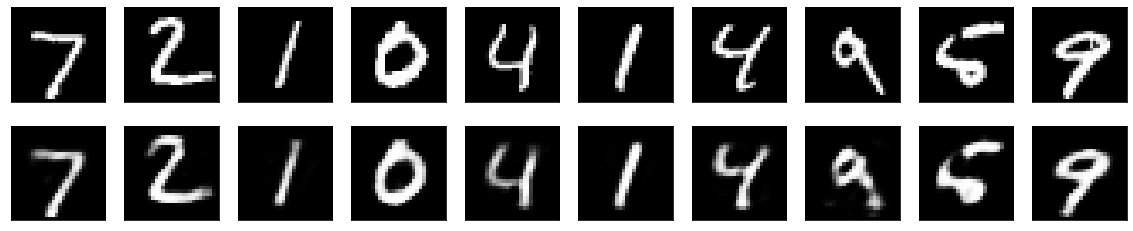

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
